In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 22)

In [3]:
# COSMIC DATA FROM TCGA + TCGA
# cosmic_cgrh38 = pd.read_table("../raw_data/CosmicCompleteGeneExpression_GRCh38.tsv")
cosmic_cgrh37 = pd.read_table("../raw_data/CosmicCompleteGeneExpression_GRCh37.tsv")


In [ ]:
cosmic_blood_v3 = pd.read_table("../tables_output/blood_PRO_final_v3.PRO", sep = '\t')

In [6]:
# tcga_clinical = pd.read_table("../raw_data/NIH_GDC_DataPortal/LAML_DLBC_clinical.cases_selection.2018-10-13/clinical.tsv")
# tcga_exposure = pd.read_table("../raw_data/NIH_GDC_DataPortal/LAML_DLBC_clinical.cases_selection.2018-10-13/exposure.tsv")

In [11]:
tcga_LAML_DLBC_aliquot = pd.read_table("../raw_data/NIH_GDC_DataPortal/LAML_DLBC_biospecimen.cases_selection.2018-10-13/aliquot.tsv")

In [12]:
# FLUX SIMULATOR FILES 
example_PRO = pd.read_table("../../flux-simulator-1.2.1/simulator-fastq-example/example.pro", sep = "\t", header = None)

In [13]:
example_GTF = pd.read_table("../../flux-simulator-1.2.1/simulator-fastq-example/annotation.gtf", sep = "\t", header = None)

In [14]:
ensembl69_gtf = pd.read_table("../raw_data/Homo_sapiens.GRCh37.69_subset-chr12-chr21.gtf", header = None, sep = '\t')

In [ ]:
# ensembl69_gtf_full = pd.read_table("../raw_data/Homo_sapiens.GRCh37.69.gtf", header = None, sep = '\t')

cosmic_blood_v3 = pd.read_table("../tables_output/")

## Data exploration - Metadata 

In [55]:
# tcga_LAML_DLBC_sample = pd.read_table("../raw_data/NIH_GDC_DataPortal/LAML_DLBC_clinical.cases_selection.2018-10-13/clinical.tsv")
# tcga_LAML_DLBC_sample.head(2) # Not helpful

In [15]:
tcga_LAML_DLBC_aliquot.head(2)

,aliquot_id,aliquot_submitter_id,case_id,case_submitter_id,project_id,sample_id,sample_submitter_id,portion_id,portion_submitter_id,analyte_id,analyte_submitter_id,analyte_type_id,state,analyte_type,amount,concentration,source_center
0,e4b17175-746c-47db-a509-7320119351b2,TCGA-AB-2876-11A-01W-0732-08,80017c88-e07f-4bf6-ad00-87f3e5473d6d,TCGA-AB-2876,TCGA-LAML,f1533c35-e783-46d5-ac3a-58dbfe70165b,TCGA-AB-2876-11A,b5e8e075-8fba-4351-a029-6b75841113f3,TCGA-AB-2876-11A-01,77cf51be-f73c-4885-b80c-57df7c9dae02,TCGA-AB-2876-11A-01W,--,released,--,--,--,23
1,f28d283b-5c4d-4528-bcd0-c8c041c52965,TCGA-AB-2876-11A-01D-0730-08,80017c88-e07f-4bf6-ad00-87f3e5473d6d,TCGA-AB-2876,TCGA-LAML,f1533c35-e783-46d5-ac3a-58dbfe70165b,TCGA-AB-2876-11A,b5e8e075-8fba-4351-a029-6b75841113f3,TCGA-AB-2876-11A-01,8a9821e1-c613-4a11-b710-57020cd06326,TCGA-AB-2876-11A-01D,--,released,--,--,--,23


In [16]:
tcga_LAML_DLBC_aliquot['case_submitter_id'].unique()[0:3]

array(['TCGA-AB-2876', 'TCGA-AB-2992', 'TCGA-AB-2849'], dtype=object)

---

## Data exploration - PRO format (Flux simulator)

In [17]:
example_PRO.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2micron:252-1523W,R0010W,CDS,1272,0.00047,47,0.00038,159,0.00070,7,0.16588,25,1.08316
1,2micron:3271-3816W,R0030W,CDS,546,0.00080,80,0.00039,164,0.00040,4,0.12821,0,nan
2,2micron:1887-3008C,R0020C,CDS,1122,0.00074,74,0.00060,251,0.00060,6,0.15954,22,1.03826
3,2micron:5308-6198C,R0040C,CDS,891,0.00004,4,0.00002,9,0.00010,1,0.03928,0,nan
4,chrI:335-792W,YAL069W,CDS,315,0.00005,5,0.00001,3,0.00000,0,0.00000,0,nan


In [18]:
cols_pro = ['Locus', 'Transcript_ID', 'Coding', 'Length', 'Expressed Fraction', 'Expressed Number', 'Library Fraction', 'Library Number', 'Sequenced Fraction', 'Sequenced Number', 'Covered Fraction', 'Chi Square', 'Coefficient of Variation']

In [19]:
example_PRO.columns = cols_pro

In [20]:
example_PRO.head(2)

,Locus,Transcript_ID,Coding,Length,Expressed Fraction,Expressed Number,Library Fraction,Library Number,Sequenced Fraction,Sequenced Number,Covered Fraction,Chi Square,Coefficient of Variation
0,2micron:252-1523W,R0010W,CDS,1272,0.00047,47,0.00038,159,0.00070,7,0.16588,25,1.08316
1,2micron:3271-3816W,R0030W,CDS,546,0.00080,80,0.00039,164,0.00040,4,0.12821,0,nan


In [21]:
example_PRO.describe()

,Length,Expressed Fraction,Expressed Number,Library Fraction,Library Number,Sequenced Fraction,Sequenced Number,Covered Fraction,Chi Square,Coefficient of Variation
count,6689.00000,6689.00000,6689.00000,6689.00000,6689.00000,6689.00000,6689.00000,6689.00000,6689.00000,342.00000
mean,1355.11287,0.00015,14.95096,0.00015,62.30692,0.00015,1.49155,0.02895,2.80655,1.36341
std,1140.56555,0.00040,39.69634,0.00049,206.13285,0.00052,5.22982,0.06404,38.91149,1.03681
min,51.00000,0.00002,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.12093
25%,540.00000,0.00004,4.00000,0.00003,12.00000,0.00000,0.00000,0.00000,0.00000,0.76937
50%,1077.00000,0.00007,7.00000,0.00006,24.00000,0.00000,0.00000,0.00000,0.00000,1.13989
75%,1770.00000,0.00014,14.00000,0.00013,55.00000,0.00010,1.00000,0.03618,0.00000,1.57339
max,14733.00000,0.01494,1494.00000,0.01678,6992.00000,0.01794,179.00000,0.96571,1840.00000,8.74004


## Distribution of PRO parameters

### Expressed Fraction/Number

* Expressed Fraction: fraction of RNA molecules that represent transcripts that are qualitatively equal to this RNA form
* Expressed Number: absolute number of expressed RNA molecules

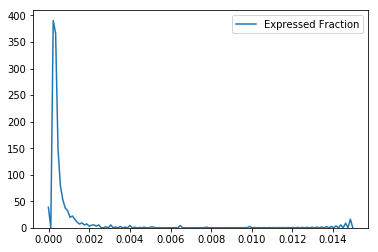

In [47]:
# Expressed Fractions distribution of all genes .PRO
sns.kdeplot(example_PRO['Expressed Fraction'])
plt.show()

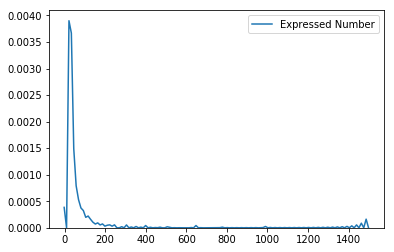

In [48]:
sns.kdeplot(example_PRO['Expressed Number'])
plt.show()

> The expressed fraction and expressed number have the exact same distribution, so one of a scaled version of the other one: expressed fraction = expressed number/10000

---

### Sequenced Fraction/Number

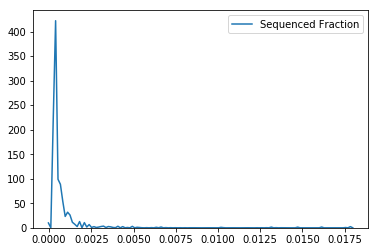

In [42]:
# Sequenced Fraction distribution of all genes .PRO
sns.kdeplot(example_PRO['Sequenced Fraction'])
plt.show()

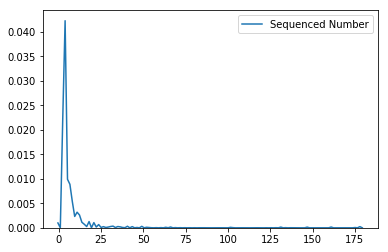

In [49]:
# Sequenced Numbers distribution of all genes .PRO
sns.kdeplot(example_PRO['Sequenced Number'])
plt.show()

In [34]:
np.array(example_PRO['Sequenced Fraction']).sum()

1.0

>  The sum of all expressed fractions = 1, so our fractions exposures sum should also be one
> In order to start with z-score and end up with these 

### Library Fraction/Number

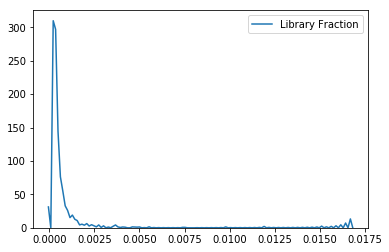

In [37]:
# Library fraction distribution of all genes .PRO
sns.kdeplot(example_PRO['Library Fraction'])
plt.show()

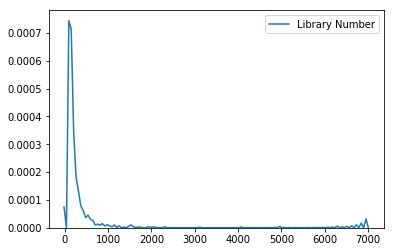

In [38]:
# Library "numbers" distribution of all genes .PRO
sns.kdeplot(example_PRO['Library Number'])
plt.show()

> Library Fraction: "fraction of cDNA molecules in the final library that have been produced from this transcript"
> Library Number: The very misleading column name "Library Number" actually refers to the "absolute number of cDNA fragments generated from this transcript" 

In [40]:
print(np.array(example_PRO['Library Fraction']).sum())
print(np.array(example_PRO['Library Number']).sum())

1.0
416771


---
## Data exploration - GTF format (Flux simulator)

In [22]:
example_GTF.head()

,0,1,2,3,4,5,6,7,8
0,2micron,sacCer2_sgdGene,start_codon,252,254,0.00000,+,.,"gene_id ""R0010W""; transcript_id ""R0010W"";"
1,2micron,sacCer2_sgdGene,CDS,252,1520,0.00000,+,0,"gene_id ""R0010W""; transcript_id ""R0010W"";"
2,2micron,sacCer2_sgdGene,exon,252,1523,0.00000,+,.,"gene_id ""R0010W""; transcript_id ""R0010W"";"
3,2micron,sacCer2_sgdGene,stop_codon,1521,1523,0.00000,+,.,"gene_id ""R0010W""; transcript_id ""R0010W"";"
4,2micron,sacCer2_sgdGene,start_codon,3271,3273,0.00000,+,.,"gene_id ""R0030W""; transcript_id ""R0030W"";"


In [ ]:
cols_gtf = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame']

## Data exploration - TCGA

In [23]:
tcga_clinical.head(2)

,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,...,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,e3956736-adbc-49a2-a4a8-a6ae93b8faf3,TCGA-AB-2883,TCGA-LAML,male,1948,white,-22067,alive,--,not hispanic or latino,--,...,--,--,--,--,--,Bone marrow,--,--,--,--,--
1,646631ce-7a1f-4274-abb7-780b939e182f,TCGA-AB-2999,TCGA-LAML,male,1942,white,-22980,alive,--,not hispanic or latino,--,...,--,--,--,--,--,Bone marrow,--,--,--,--,--


In [24]:
tcga_clinical.head(2)

,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,vital_status,days_to_death,ethnicity,year_of_death,...,burkitt_lymphoma_clinical_variant,circumferential_resection_margin,ldh_normal_range_upper,ann_arbor_extranodal_involvement,lymph_nodes_positive,site_of_resection_or_biopsy,ajcc_pathologic_t,days_to_hiv_diagnosis,ajcc_clinical_stage,days_to_new_event,hiv_positive
0,e3956736-adbc-49a2-a4a8-a6ae93b8faf3,TCGA-AB-2883,TCGA-LAML,male,1948,white,-22067,alive,--,not hispanic or latino,--,...,--,--,--,--,--,Bone marrow,--,--,--,--,--
1,646631ce-7a1f-4274-abb7-780b939e182f,TCGA-AB-2999,TCGA-LAML,male,1942,white,-22980,alive,--,not hispanic or latino,--,...,--,--,--,--,--,Bone marrow,--,--,--,--,--


In [22]:
co_exp_genes_lst = ['ETV6', 'KIF13A', 'MAPK14', 'PAK1', 'SEMA4A', 'TGOLN2', 'TKT', 'WDFY3', 'RUNX1']

In [4]:
cosmic_cgrh38.shape
# There are 161 million lines in this aggregated dataset 

(161353200, 6)

In [5]:
cosmic_cgrh38.head(10)

,SAMPLE_ID,SAMPLE_NAME,GENE_NAME,REGULATION,Z_SCORE,ID_STUDY
0,1899661,TCGA-A7-A13F-01,ZNF282,normal,-1.023,414
1,2193736,TCGA-D6-A4Z9-01,MYADM,normal,-0.406,627
2,1900066,TCGA-D8-A1X6-01,NOP2,normal,-0.581,414
3,2385986,TCGA-KK-A8IM-01,LRRC8D,normal,0.380,435
4,2386114,TCGA-C8-A8HP-01,ZNF805,normal,1.285,414
5,2120520,TCGA-CJ-4893-01,LRRC8D,normal,1.467,416
6,1914067,TCGA-78-7163-01,NDUFA10,normal,-0.258,417
7,2339584,TCGA-BA-A4IG-01,AZGP1,normal,-0.345,627
8,2263100,TCGA-QH-A6CX-01,C9orf40,normal,0.810,545
9,2194173,TCGA-DB-5270-01,C9orf40,normal,0.021,545


In [42]:
# Unique genes
len(cosmic_cgrh38['GENE_NAME'].unique())

17915

> There is expression data on 17915 genes.

***

In [23]:
cosmic_cgrh38_co_exp = cosmic_cgrh38[cosmic_cgrh38['GENE_NAME'].isin(co_exp_genes_lst)]

In [10]:
print(cosmic_cgrh38_co_exp.shape)

(64008, 6)


In [24]:
cosmic_cgrh38_co_exp.to_csv("../tables_output/COSMIC_GE_GRCh38_ETV6_RUNX1_co_exp_genes.tsv", sep = '\t', index = False)

In [18]:
len(cosmic_cgrh38_co_exp['SAMPLE_ID'].unique())

9144

In [19]:
len(cosmic_cgrh38_co_exp['GENE_NAME'].unique())

7

## Co-expressed genes 

Subset of COSMIC expression

* 9144 samples 
* ETV6 + 7 co-expressed: 8 genes selected from co-expressed network from Farhabod and Pavlidis Supplementary (2018)
* RUNX1 

---

## Subset one sample 



In [28]:
# Store sample id in variable 
one_sample = 'TCGA-A7-A13F-01'

In [29]:
# Filter data for that one sample 
cosmic_cgrh38_1899661 = cosmic_cgrh38[cosmic_cgrh38['SAMPLE_NAME'] == one_sample]

In [34]:
# Panda df to matrix
cosmic_cgrh38_1899661_mx = cosmic_cgrh38_1899661.as_matrix()

In [45]:
cosmic_cgrh38_1899661['SAMPLE_NAME'].unique()

array(['TCGA-A7-A13F-01'], dtype=object)

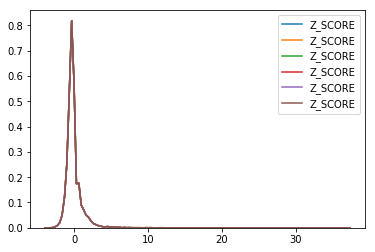

In [40]:
# Plot distribution of Z-score of all genes for one sample 
sns.kdeplot(cosmic_cgrh38_1899661.Z_SCORE)
plt.show()

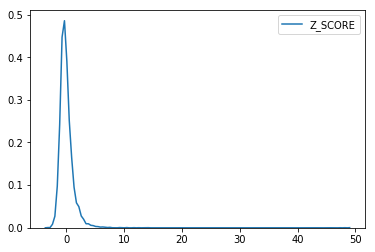

In [43]:
# Plot distribution of Z-score of one gene
sns.kdeplot(cosmic_cgrh38[cosmic_cgrh38['GENE_NAME']=="ETV6"].Z_SCORE)
plt.show()

## Subset LAML and DLBC

Those are the only hetatological cancers from TCGA expression, and although it's not the exact same cell types, at least, it's the same organ system.

In [60]:
tcga_LAML_DLBC_aliquot.columns

Index(['aliquot_id', 'aliquot_submitter_id', 'case_id', 'case_submitter_id',
       'project_id', 'sample_id', 'sample_submitter_id', 'portion_id',
       'portion_submitter_id', 'analyte_id', 'analyte_submitter_id',
       'analyte_type_id', 'state', 'analyte_type', 'amount', 'concentration',
       'source_center'],
      dtype='object')

In [75]:
## Create list of samples ids BLOOD 
samples_blood_lst = np.array(tcga_LAML_DLBC_aliquot['case_submitter_id']).tolist()

In [76]:
samples_blood_lst[0:3]

['TCGA-AB-2876', 'TCGA-AB-2876', 'TCGA-AB-2876']

In [74]:
# Create list of all COSMIC/TCGA sample ids 
samples_all_lst = (cosmic_cgrh38['SAMPLE_NAME'].unique()).tolist()

In [77]:
samples_all_lst[0:3]

['TCGA-A7-A13F-01', 'TCGA-D6-A4Z9-01', 'TCGA-D8-A1X6-01']

In [88]:
## check partial id matchs
keep_lst = []
for one_id in samples_blood_lst:
    for another_id in samples_all_lst:
        if one_id in another_id:
            keep_lst.append(another_id)

In [90]:
keep_lst[0:2]

['TCGA-AB-2992-03', 'TCGA-AB-2992-03']

In [59]:
cosmic_cgrh38.columns

Index(['SAMPLE_ID', 'SAMPLE_NAME', 'GENE_NAME', 'REGULATION', 'Z_SCORE',
       'ID_STUDY'],
      dtype='object')

In [ ]:
cosmic_cgrh38_blood = cosmic_cgrh38[cosmic_cgrh38['SAMPLE_NAME'].isin(keep_lst)]

In [94]:
cosmic_cgrh38_blood.head()

,SAMPLE_ID,SAMPLE_NAME,GENE_NAME,REGULATION,Z_SCORE,ID_STUDY


In [96]:
# cosmic_cgrh38_blood.to_csv("../tables_output/TCGA_COSMIC_blood_data.tsv", sep = "\t", index = True)

In [25]:
cosmic_cgrh38_blood = pd.read_table("../tables_output/TCGA_COSMIC_blood_data.tsv")

In [26]:
cosmic_cgrh38_blood.shape

(3909490, 7)

In [35]:
cosmic_cgrh38_blood.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [36]:
cosmic_cgrh38_blood.head(2)

,SAMPLE_ID,SAMPLE_NAME,GENE_NAME,REGULATION,Z_SCORE,ID_STUDY
0,2269806,TCGA-RQ-A68N-01,SERPINB7,normal,-0.16300,632
1,1650400,TCGA-AB-2908-03,ANGPTL5,normal,1.58300,377


In [97]:
# RUNX1 = cosmic_cgrh38_blood[cosmic_cgrh38_blood['GENE_NAME']== "RUNX1"]

In [37]:
cosmic_cgrh38_blood.describe()

,SAMPLE_ID,Z_SCORE,ID_STUDY
count,3909490.00000,3909490.00000,3909490.00000
mean,1818722.47964,0.05349,432.38462
std,277729.66047,18.28845,105.14573
min,1650295.00000,-6.02300,377.00000
25%,1650363.00000,-0.51800,377.00000
50%,1650440.00000,-0.19800,377.00000
75%,2194115.00000,0.28800,377.00000
max,2457244.00000,26116.98600,632.00000


In [38]:
cosmic_cgrh38_blood_median = cosmic_cgrh38_blood.groupby(['GENE_NAME']).median()

In [39]:
cosmic_cgrh38_blood_median.shape

(17690, 3)

In [49]:
cosmic_cgrh38_blood_median.head(2)

,Z_SCORE,ID_STUDY,GENE_NAME
0,-0.12800,377,39340
1,-0.24300,377,A1BG


In [41]:
# Add GENE_NAME columns back (from index)
cosmic_cgrh38_blood_median['GENE_NAME'] = cosmic_cgrh38_blood_median.index

In [42]:
cosmic_cgrh38_blood_median.reset_index(drop = True, inplace = True)

In [50]:
# type(cosmic_cgrh38_blood_median)

In [44]:
# Drop the sample_id (not relevant)
cosmic_cgrh38_blood_median = cosmic_cgrh38_blood_median.drop(['SAMPLE_ID'], axis = 1)

In [62]:
cosmic_cgrh38_blood_median.head()

,Z_SCORE,ID_STUDY,GENE_NAME
0,-0.12800,377,39340
1,-0.24300,377,A1BG
2,-0.13600,377,A1CF
3,-0.12400,377,A2LD1
4,-0.31200,377,A2M


In [61]:
cosmic_cgrh38_blood_median.to_csv('cosmic_cgrh38_blood_median_z.tsv', sep = '\t', index = False)

In [52]:
min_Z_SCORE = cosmic_cgrh38_blood_median['Z_SCORE'].min()
print(abs(min_Z_SCORE))

1.098


In [63]:
## Add min negative Z-score value to ensure Z-SCORE values are positive 
cosmic_cgrh38_blood_median['Z_SCORE_positive'] = cosmic_cgrh38_blood_median['Z_SCORE'] + abs(min_Z_SCORE) 

In [64]:
cosmic_cgrh38_blood_median.shape

(17690, 4)

In [65]:
cosmic_cgrh38_blood_median.head(2)

,Z_SCORE,ID_STUDY,GENE_NAME,Z_SCORE_positive
0,-0.12800,377,39340,0.97000
1,-0.24300,377,A1BG,0.85500


In [125]:
## Scale the distribution of scores to match the .PRO file 
### Look at .PRO format again
example_PRO.head(5)

,Locus,Transcript_ID,Coding,Length,Expressed Fraction,Expressed Number,Library Fraction,Library Number,Sequenced Fraction,Sequenced Number,Covered Fraction,Chi Square,Coefficient of Variation
0,2micron:252-1523W,R0010W,CDS,1272,0.00047,47,0.00038,159,0.00070,7,0.16588,25,1.08316
1,2micron:3271-3816W,R0030W,CDS,546,0.00080,80,0.00039,164,0.00040,4,0.12821,0,nan
2,2micron:1887-3008C,R0020C,CDS,1122,0.00074,74,0.00060,251,0.00060,6,0.15954,22,1.03826
3,2micron:5308-6198C,R0040C,CDS,891,0.00004,4,0.00002,9,0.00010,1,0.03928,0,nan
4,chrI:335-792W,YAL069W,CDS,315,0.00005,5,0.00001,3,0.00000,0,0.00000,0,nan


In [66]:
# Store Z-score RNAseq distribution to PRO df to modify 
blood_PRO = cosmic_cgrh38_blood_median

In [67]:
blood_PRO.head(2)

,Z_SCORE,ID_STUDY,GENE_NAME,Z_SCORE_positive
0,-0.12800,377,39340,0.97000
1,-0.24300,377,A1BG,0.85500


In [267]:
# No need 

In [68]:
# Store sum of Z-score as a normalizing variable for later
total_Z_SCORE = sum(np.array(cosmic_cgrh38_blood_median['Z_SCORE_positive']))
print(total_Z_SCORE)

15894.22


In [69]:
# Add column for Expressed Fraction, which will be  
blood_PRO['Expressed Fraction'] = blood_PRO['Z_SCORE_positive']/(total_Z_SCORE) 

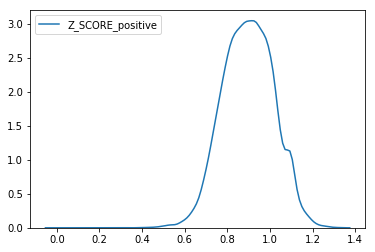

In [70]:
## COMPARE Z_SCORE and Expressed Fraction distributions 
sns.kdeplot(blood_PRO.Z_SCORE_positive)
plt.show()

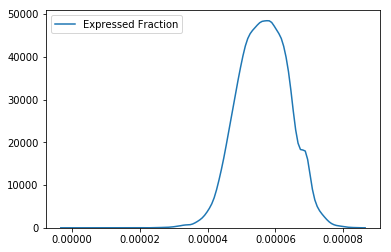

In [71]:
sns.kdeplot(blood_PRO['Expressed Fraction'])
plt.show()

## Ensembl69 GTF file 


In [74]:
ensembl69_gtf.columns = ['chr', 'rna_type', 'transcript_region', 'start', 'end', '5', 'strand', '7', 'transcript_info']

In [75]:
def tidy_split(df, column, sep=';', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.
    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row
    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df.reset_index(drop=True)

In [76]:
info_data = ensembl69_gtf['transcript_info'].str.split(';', expand=True)
info_data = info_data.iloc[:, :7]
info_data.columns = ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 
                     'gene_biotype', 'transcript_name', 'exon_id']
info_data = info_data.fillna('exon id "none"')
info_data['exon_id'] = info_data['exon_id'].replace('', 'exon id "none"')

In [77]:
def update_columns(data, column):
    data[column] = data[column].map(lambda x: x.split('"')[1])
    return data
    
for i in info_data.columns:
    info_data = update_columns(info_data, i)

In [78]:
ensembl69_gtf_expand = pd.concat([ensembl69_gtf, info_data], axis=1)

In [79]:
ensembl69_gtf_expand.head(2)

,chr,rna_type,transcript_region,start,end,5,strand,7,transcript_info,gene_id,transcript_id,exon_number,gene_name,gene_biotype,transcript_name,exon_id
0,12,lincRNA,exon,67607,67967,.,+,.,"gene_id ""ENSG00000249054""; transcript_id ""ENS...",ENSG00000249054,ENST00000504074,1,RP11-598F7.1,lincRNA,RP11-598F7.1-001,ENSE00002076759
1,12,lincRNA,exon,68211,68415,.,+,.,"gene_id ""ENSG00000249054""; transcript_id ""ENS...",ENSG00000249054,ENST00000504074,2,RP11-598F7.1,lincRNA,RP11-598F7.1-001,ENSE00002050265


In [80]:
# Check that only chr12 and chr21 are there
ensembl69_gtf_expand['chr'].unique()

array([12, 21])

In [81]:
genes_chr12_chr21 = ensembl69_gtf_expand['gene_name'].tolist()

In [82]:
print(len(genes_chr12_chr21))

151032


In [84]:
unique_genes = np.unique(np.array(genes_chr12_chr21))
print(len(unique_genes))

3201


In [283]:
unique_genes[unique_genes == "RUNX1"]

array(['RUNX1'],
      dtype='<U18')

In [85]:
blood_PRO_chr12_chr21 = blood_PRO[blood_PRO['GENE_NAME'].isin(unique_genes)]

In [86]:
blood_PRO.shape

(17690, 5)

In [87]:
blood_PRO_chr12_chr21.shape

(1121, 5)

In [89]:
blood_PRO_chr12_chr21.head(2)

,Z_SCORE,ID_STUDY,GENE_NAME,Z_SCORE_positive,Expressed Fraction
4,-0.31200,377,A2M,0.78600,0.00005
5,-0.24000,377,A2ML1,0.85800,0.00005


In [100]:
blood_PRO_chr12_chr21 = blood_PRO_chr12_chr21.rename(columns = {'GENE_NAME':'gene_name'})

In [101]:
blood_PRO_chr12_chr21.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction
4,-0.31200,377,A2M,0.78600,0.00005
5,-0.24000,377,A2ML1,0.85800,0.00005


### Take arbitrary number of 10 million transcripts for chr12+chr21 together 

> Need to re-normalize to new total of z-score (since only 2 chromosomes)

In [116]:
total_z_chr12_chr21 = sum(np.array(blood_PRO_chr12_chr21['Z_SCORE_positive']))
total_z_chr12_chr21

1024.9209999999982

> Add column Expressed Fraction (corrected for chr12 + chr21 subset)

In [120]:
blood_PRO_chr12_chr21['Expressed Fraction'] = np.array(blood_PRO_chr12_chr21['Z_SCORE_positive'])/total_z_chr12_chr21

In [121]:
blood_PRO_chr12_chr21.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction
4,-0.31200,377,A2M,0.78600,0.00077
5,-0.24000,377,A2ML1,0.85800,0.00084


In [122]:
sum(blood_PRO_chr12_chr21['Expressed Fraction'])

1.0000000000000004

> Add column Expressed Number based on a total RNA seq reads count = 10 millions  (arbitrary value)

In [123]:
blood_PRO_chr12_chr21['Expressed Number'] = blood_PRO_chr12_chr21['Expressed Fraction'] * 10000000

---

In [124]:
ensembl69_gtf_expand.columns

Index(['chr', 'rna_type', 'transcript_region', 'start', 'end', '5', 'strand',
       '7', 'transcript_info', 'gene_id', 'transcript_id', 'exon_number',
       'gene_name', 'gene_biotype', 'transcript_name', 'exon_id'],
      dtype='object')

In [127]:
ensembl69_gtf_expand.head(2)

,chr,rna_type,transcript_region,start,end,5,strand,7,transcript_info,gene_id,transcript_id,exon_number,gene_name,gene_biotype,transcript_name,exon_id
0,12,lincRNA,exon,67607,67967,.,+,.,"gene_id ""ENSG00000249054""; transcript_id ""ENS...",ENSG00000249054,ENST00000504074,1,RP11-598F7.1,lincRNA,RP11-598F7.1-001,ENSE00002076759
1,12,lincRNA,exon,68211,68415,.,+,.,"gene_id ""ENSG00000249054""; transcript_id ""ENS...",ENSG00000249054,ENST00000504074,2,RP11-598F7.1,lincRNA,RP11-598F7.1-001,ENSE00002050265


In [128]:
ensembl69_gtf_expand_subset = ensembl69_gtf_expand[['chr', 'start', 'end', 'strand', 'gene_id', 'transcript_id', 'gene_name']]

In [129]:
ensembl69_gtf_expand_subset.shape

(151032, 7)

In [133]:
# Remove duplicate 
ensembl69_gtf_expand_subset_uniq = ensembl69_gtf_expand_subset.drop_duplicates()

> Merge the draft PRO expression data to GTF to create missing columns 

In [134]:
blood_PRO_expand = pd.merge(blood_PRO_chr12_chr21, ensembl69_gtf_expand_subset_uniq , how = 'inner')

### blood_PRO_expand to remake = doesn't work 

In [206]:
# blood_PRO_expand[blood_PRO_expand['gene_name'] == "A2M"]

In [136]:
sum(blood_PRO_expand['Expressed Fraction'])

84.284449240482431

> There are multiple transcripts for each gene -> re-normalize to the sum of Z_SCORE_positive would cause a gene with multiple transcripts to appear more expressed. 

It would make more sense to add a count_transcript_per_gene column and divide both the Expressed Fraction and Expressed Number column by that count in order to preserve the proportion 

### Find transcript min (start of full transcript) and max (end of full transcript)


> The start and end are the ones from each coding parts of the gene, and not absolute start and end of the transcript 

Need to replace the "exon-level" start/end by gene-level start/end 

In [293]:
transcripts_min = blood_PRO_expand.groupby(['transcript_id'])[['start']].first().drop_duplicates()

In [294]:
transcripts_min = transcripts_min.dropna()
# type(transcripts_min)
transcripts_min.head(2)

,start
transcript_id,
ENST00000000412,9102084
ENST00000001008,2904119


In [295]:
transcripts_min['transcript_id'] = transcripts_min.index
transcripts_min = transcripts_min.reset_index(drop = True)

In [296]:
transcripts_min.head(2)

,start,transcript_id
0,9102084,ENST00000000412
1,2904119,ENST00000001008


In [308]:
transcripts_max = transcripts_max.dropna()
transcripts_max = blood_PRO_expand.groupby(['transcript_id'])[['end']].max().drop_duplicates()

In [309]:
transcripts_max['transcript_id'] = transcripts_max.index 
transcripts_max = transcripts_max.dropna()

In [310]:
transcripts_max = transcripts_max.reset_index(drop  = True)
transcripts_max.head(2)

,end,transcript_id
0,9102551,ENST00000000412
1,2913124,ENST00000001008


In [311]:
transcripts_start_end = pd.merge(transcripts_min, transcripts_max, how= 'left')

In [312]:
print(transcripts_start_end.shape)
transcripts_start_end.head(2)

(6892, 3)


,start,transcript_id,end
0,9102084,ENST00000000412,9102551.00000
1,2904119,ENST00000001008,2913124.00000


In [313]:
transcripts_start_end  = transcripts_start_end.dropna()

In [314]:
transcripts_start_end['end'] = transcripts_start_end['end'].astype(int)

In [315]:
transcripts_start_end.head(2)

,start,transcript_id,end
0,9102084,ENST00000000412,9102551
1,2904119,ENST00000001008,2913124


In [316]:
# Write start/end of full transcripts to file 
transcripts_start_end.to_csv("../tables_output/chr12_chr21_start_end_transcripts.tsv", sep = '\t', index = False)

In [339]:
ensembl69_gtf_expand.columns 

Index(['chr', 'rna_type', 'transcript_region', 'start', 'end', '5', 'strand',
       '7', 'transcript_info', 'gene_id', 'transcript_id', 'exon_number',
       'gene_name', 'gene_biotype', 'transcript_name', 'exon_id'],
      dtype='object')

In [378]:
np.unique(np.array(ensembl69_gtf_expand['gene_biotype']))

array(['3prime_overlapping_ncrna', 'IG_V_gene', 'antisense', 'lincRNA',
       'miRNA', 'misc_RNA', 'polymorphic_pseudogene',
       'processed_transcript', 'protein_coding', 'pseudogene', 'rRNA',
       'sense_intronic', 'sense_overlapping', 'snRNA', 'snoRNA'], dtype=object)

In [383]:
ensembl69_gtf_gene_subset2 = ensembl69_gtf_expand[['chr', 'gene_name', 'strand', 'transcript_id', 'gene_biotype']]

In [384]:
ensembl69_gtf_gene_subset2.head(2)

,chr,gene_name,strand,transcript_id,gene_biotype
0,12,RP11-598F7.1,+,ENST00000504074,lincRNA
1,12,RP11-598F7.1,+,ENST00000504074,lincRNA


In [385]:
transcripts_start_end_genes = pd.merge(transcripts_start_end, ensembl69_gtf_gene_subset2)

In [386]:
transcripts_start_end_genes.head()
transcripts_start_end_genes = transcripts_start_end_genes.drop_duplicates()

### Correct blood_PRO_expand

In [387]:
blood_PRO_expand =  pd.merge(blood_PRO_chr12_chr21, transcripts_start_end_genes, how = 'inner')

In [388]:
# Count the number of transcripts and assume equal contribution of RNA from each transcript not accounting for length
blood_PRO_expand['count_transcripts'] = blood_PRO_expand.groupby('gene_name')['gene_name'].transform('count')

In [389]:
blood_PRO_expand['count_transcripts'] = blood_PRO_expand.groupby('gene_name')['gene_name'].transform('count')

In [390]:
blood_PRO_expand.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction,Expressed Number,start,transcript_id,end,chr,strand,gene_biotype,count_transcripts
0,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268360,ENST00000318602,9268753,12,-,protein_coding,8
1,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268724,ENST00000404455,9268825,12,-,protein_coding,8


In [392]:
blood_PRO_expand['Expressed Fraction - Transcript'] = blood_PRO_expand['Expressed Fraction']/blood_PRO_expand['count_transcripts']

In [393]:
blood_PRO_expand['Expressed Number - Transcript'] = blood_PRO_expand['Expressed Number']/blood_PRO_expand['count_transcripts']

In [394]:
blood_PRO_expand.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction,Expressed Number,start,transcript_id,end,chr,strand,gene_biotype,count_transcripts,Expressed Fraction - Transcript,Expressed Number - Transcript
0,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268360,ENST00000318602,9268753,12,-,protein_coding,8,0.00010,958.61047
1,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268724,ENST00000404455,9268825,12,-,protein_coding,8,0.00010,958.61047


In [395]:
sum(blood_PRO_expand['Expressed Fraction - Transcript'])

0.99999999999999711

In [396]:
blood_PRO_expand.shape

(6454, 15)

In [397]:
blood_PRO_expand_gene = blood_PRO_expand.drop_duplicates()

> Add Locus column (chrom:start-end[W|C])

In [398]:
blood_PRO_expand['strand_WC'] = pd.Series(blood_PRO_expand['strand']).str.replace('+', 'W')
blood_PRO_expand['strand_WC'] = pd.Series(blood_PRO_expand['strand']).str.replace('-', 'C')

In [399]:
blood_PRO_expand.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction,Expressed Number,start,transcript_id,end,chr,strand,gene_biotype,count_transcripts,Expressed Fraction - Transcript,Expressed Number - Transcript,strand_WC
0,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268360,ENST00000318602,9268753,12,-,protein_coding,8,0.00010,958.61047,C
1,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268724,ENST00000404455,9268825,12,-,protein_coding,8,0.00010,958.61047,C


In [400]:
blood_PRO_expand['Locus'] = blood_PRO_expand['chr'].astype(str) + ":" + blood_PRO_expand['start'].astype(str) + "-" + blood_PRO_expand['end'].astype(str) + blood_PRO_expand['strand_WC'].astype(str)

In [401]:
blood_PRO_expand.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction,Expressed Number,start,transcript_id,end,chr,strand,gene_biotype,count_transcripts,Expressed Fraction - Transcript,Expressed Number - Transcript,strand_WC,Locus
0,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268360,ENST00000318602,9268753,12,-,protein_coding,8,0.00010,958.61047,C,12:9268360-9268753C
1,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268724,ENST00000404455,9268825,12,-,protein_coding,8,0.00010,958.61047,C,12:9268724-9268825C


In [425]:
blood_PRO_expand['Locus_v2'] = blood_PRO_expand['chr'].astype(str) + ":" + blood_PRO_expand['start'].astype(str) + "-" + blood_PRO_expand['end'].astype(str) + blood_PRO_expand['strand'].astype(str)

In [426]:
blood_PRO_expand.head(2)

,Z_SCORE,ID_STUDY,gene_name,Z_SCORE_positive,Expressed Fraction,Expressed Number,start,transcript_id,end,chr,strand,gene_biotype,count_transcripts,Expressed Fraction - Transcript,Expressed Number - Transcript,strand_WC,Locus,Coding,Length,Locus_v2
0,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268360,ENST00000318602,9268753,12,-,protein_coding,8,0.00010,958.61047,C,12:9268360-9268753C,CDS,393,12:9268360-9268753-
1,-0.31200,377,A2M,0.78600,0.00077,7668.88375,9268724,ENST00000404455,9268825,12,-,protein_coding,8,0.00010,958.61047,C,12:9268724-9268825C,CDS,101,12:9268724-9268825-


In [402]:
# For now, all genes are coding ... 
# blood_PRO_expand['Coding'] = 'CDS'

In [413]:
def determine_coding(x):
    if x=='protein_coding':
        return('CDS')
    else:
        return('NC')

In [414]:
blood_PRO_expand['Coding'] = blood_PRO_expand['gene_biotype'].map(determine_coding)

In [416]:
np.unique(np.array(blood_PRO_expand['Coding']))

array(['CDS', 'NC'], dtype=object)

In [417]:
blood_PRO_expand['Length'] = blood_PRO_expand['end'] - blood_PRO_expand['start']

In [418]:
blood_PRO_final = blood_PRO_expand[['Locus', 'transcript_id', 'Coding', 'Length', 'Expressed Fraction - Transcript', 'Expressed Number - Transcript']]

In [431]:
blood_PRO_final_v2 = blood_PRO_expand[['Locus_v2', 'transcript_id', 'Coding', 'Length', 'Expressed Fraction - Transcript', 'Expressed Number - Transcript']]

In [419]:
blood_PRO_final.columns = ['Locus', 'Transcript_ID', 'Coding', 'Length', 'Expressed Fraction', 'Expressed Number']

In [432]:
blood_PRO_final_v2.columns = ['Locus', 'Transcript_ID', 'Coding', 'Length', 'Expressed Fraction', 'Expressed Number']

In [422]:
# blood_PRO_final['Exp_v2'] = blood_PRO_final['Expressed Fraction'].astype(str)

/Users/mylinhthibodeau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [433]:
blood_PRO_final.head(2)

,Locus,Transcript_ID,Coding,Length,Expressed Fraction,Expressed Number,Exp_v2
0,12:9268360-9268753C,ENST00000318602,CDS,393,0.00010,958.61047,9.58610468514e-05
1,12:9268724-9268825C,ENST00000404455,CDS,101,0.00010,958.61047,9.58610468514e-05


In [434]:
blood_PRO_final_v2.head()

,Locus,Transcript_ID,Coding,Length,Expressed Fraction,Expressed Number
0,12:9268360-9268753-,ENST00000318602,CDS,393,0.00010,958.61047
1,12:9268724-9268825-,ENST00000404455,CDS,101,0.00010,958.61047
2,12:9242952-9243126-,ENST00000462568,CDS,174,0.00010,958.61047
3,12:9254043-9254152-,ENST00000472360,CDS,109,0.00010,958.61047
4,12:9221336-9221551-,ENST00000495442,CDS,215,0.00010,958.61047


In [421]:
blood_PRO_final.to_csv('../tables_output/blood_PRO_final_v2.tsv', sep = "\t", index = False, header = None)

In [435]:
blood_PRO_final_v2.to_csv('../tables_output/blood_PRO_final_v3.tsv', sep = "\t", index = False, header = None)